<a href="https://colab.research.google.com/github/ayanokohjikimimaro/Data_Read/blob/master/speechcomand_gmmhmm_180228.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hidden Markov Models (HMMs) are powerful, flexible methods for representing and classifying data with trends over time, and have been a key component in speech recognition systems for many years.

I found it very difficult to find a good example (with code) of a simple speech recognition system, so I decided to create this post. Though this implementation won't win any awards for "Best Speech Recognizer", I hope it will provide some insight into how HMMs can be used for speech recognition and other tasks.
<!-- TEASER_END -->

In this post, I will define what Hidden Markov Models are, show how to implement one form (Gaussian Mixture Model HMM, GMM-HMM) using numpy + scipy, and how to use this algorithm for single speaker speech recognition. For a more "production grade" HMM implementation, see [hmmlearn](https://github.com/hmmlearn/hmmlearn) which holds the HMM implementations that were formerly a part of [sklearn](http://scikit-learn.org/stable/).

隠れマルコフモデル（ＨＭＭ）は、経時的傾向と共にデータを表現し分類するための強力で柔軟な方法であり、長年にわたり音声認識システムにおける重要な構成要素であった。

簡単な音声認識システムの良い例（コード付き）を見つけるのは非常に難しいので、この記事を作成することにしました。 この実装は "Best Speech Recognizer"の賞を受賞することはありませんが、HMMを音声認識やその他のタスクに使用する方法についての洞察を提供することを願っています。
<！ -  TEASER_END  - >

この記事では、隠れマルコフモデルとは何かを定義し、numpy + scipyを使用して1つの形式（ガウス混合モデルHMM、GMM-HMM）を実装する方法、およびこのアルゴリズムを単一話者音声認識に使用する方法を示します。 より「プロダクショングレード」のHMM実装については、以前は[sklearn]（http：// scikit-learn）の一部であったHMM実装を保持している[hmmlearn]（https://github.com/hmmlearn/hmmlearn）を参照してください。 org / stable /）

Data
----

To demonstrate this algorithm, we need a dataset to operate on. I have chosen to use the sample dataset from [this Google Code project by Hakon Sandsmark](https://code.google.com/p/hmm-speech-recognition/downloads/list). I also used this code as a reference when creating my own implementation of a Guassian Mixture Model HMM (GMM-HMM). This aided in testing my implementation, as well as giving a frame of reference for performance. 

Other available datasets are largely multispeaker, but the simple frequency peak features used in this example do not work in the multispeaker regime (different speakers have different frequency content for the same word! Let alone male/female speech differences). Future work will cover more advanced feature extraction techniques for audio, and extend these examples to multispeaker recognition.

このアルゴリズムを実演するためには、操作するデータセットが必要です。 Hakon SandsmarkによるこのGoogle Codeプロジェクトのサンプルデータセットを使用することにしました。 私はGuassian混合モデルHMM（GMM-HMM）の私自身の実装を作成するときに参照としてこのコードも使いました。 これは私の実装をテストするのを助け、そしてパフォーマンスのための基準の枠組みを与えるのを助けました。

他の利用可能なデータセットは主にマルチスピーカーですが、この例で使用されている単純な周波数ピーク機能はマルチスピーカー体制では機能しません（同じ単語に対して異なるスピーカーは異なる周波数成分を持っています！ 今後の作業では、オーディオ用のより高度な特徴抽出手法を取り上げ、これらの例をマルチスピーカー認識に拡張します。

# Drive Linked

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install librosa
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import glob
from matplotlib.colors import ListedColormap
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import pickle
from IPython.display import Image
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import svm
import scipy as sp
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import time
from scipy import signal
from scipy.io import wavfile
from numpy.lib.stride_tricks import as_strided
import scipy.stats as st

In [0]:
def calculate_melsp(x, n_fft=64, hop_length=32, n_mels=128):#1024,128
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=n_mels)
    return melsp

def peakfind(x, n_peaks, l_size=1, r_size=1, c_size=1, f=np.mean):
    win_size = l_size + r_size + c_size
    shape = x.shape[:-1] + (x.shape[-1] - win_size + 1, win_size)
    strides = x.strides + (x.strides[-1],)
    xs = as_strided(x, shape=shape, strides=strides)
    def is_peak(x):
        centered = (np.argmax(x) == l_size + int(c_size/2))
        l = x[:l_size]
        c = x[l_size:l_size + c_size]
        r = x[-r_size:]
        passes = np.max(c) > np.max([f(l), f(r)])
        if centered and passes:
            return np.max(c)
        else:
            return -1
    r = np.apply_along_axis(is_peak, 1, xs)
    top = np.argsort(r, None)[::-1]
    heights = r[top[:n_peaks]]
    #Add l_size and half - 1 of center size to get to actual peak location
    top[top > -1] = top[top > -1] + l_size + int(c_size / 2.)
    return heights, top[:n_peaks]

class gmmhmm:
    #This class converted with modifications from https://code.google.com/p/hmm-speech-recognition/source/browse/Word.m
    def __init__(self, n_states):
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)
        
        #Normalize random initial state
        self.prior = self._normalize(self.random_state.rand(self.n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(self.n_states, self.n_states))
        
        self.mu = None
        self.covs = None
        self.n_dims = None
           
    def _forward(self, B):
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = B[:, t] * self.prior.ravel()
            else:
                alpha[:, t] = B[:, t] * np.dot(self.A.T, alpha[:, t - 1])
         
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood = log_likelihood + np.log(alpha_sum)
        return log_likelihood, alpha
    
    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);
           
        beta[:, -1] = np.ones(B.shape[0])
            
        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.A, (B[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta
    
    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for s in range(self.n_states):
            #Needs scipy 0.14
            np.random.seed(self.random_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mu[:, s].T, cov=self.covs[:, :, s].T)
            #This function can (and will!) return values >> 1
            #See the discussion here for the equivalent matlab function
            #https://groups.google.com/forum/#!topic/comp.soft-sys.matlab/YksWK0T74Ak
            #Key line: "Probabilities have to be less than 1,
            #Densities can be anything, even infinite (at individual points)."
            #This is evaluating the density at individual points...
        return B
    
    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)
    
    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)
    
    def _em_init(self, obs):
        #Using this _em_init function allows for less required constructor args
        if self.n_dims is None:
            self.n_dims = obs.shape[0]
        if self.mu is None:
            subset = self.random_state.choice(np.arange(self.n_dims), size=self.n_states, replace=False)
            self.mu = obs[:, subset]
        if self.covs is None:
            self.covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
            self.covs += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self
    
    def _em_step(self, obs): 
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        T = obs.shape[1]
        
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)
        
        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, T))
        
        for t in range(T - 1):
            partial_sum = self.A * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
              
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)
        
        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)
        
        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
        
        gamma_state_sum = np.sum(gamma, axis=1)
        #Set zeros to 1 before dividing
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)
        
        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
            partial_covs = np.dot(gamma_obs, obs.T) / gamma_state_sum[s] - np.dot(expected_mu[:, s], expected_mu[:, s].T)
            #Symmetrize
            partial_covs = np.triu(partial_covs) + np.triu(partial_covs).T - np.diag(partial_covs)
        
        #Ensure positive semidefinite by adding diagonal loading
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]
        
        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        return log_likelihood
    
    def fit(self, obs, n_iter=15):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            for i in range(n_iter):
                self._em_init(obs)
                log_likelihood = self._em_step(obs)
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            for n in range(count):
                for i in range(n_iter):
                    self._em_init(obs[n, :, :])
                    log_likelihood = self._em_step(obs[n, :, :])
        return self
    
    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            return log_likelihood
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            out = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                out[n] = log_likelihood
            return out
          
def sigmoid(x,a=1,b=0):
    return 1.0 / (1.0 + np.exp(-(a*x+b)))


## データリード

In [122]:
file_path2 = '/content/drive/My Drive/speech_commands_v0.01/'

fpaths = []
labels = []
spoken = []
for f in os.listdir(file_path2):
    for w in os.listdir(file_path2 + f):
        fpaths.append(file_path2 + f + '/' + w)
        labels.append(f)
        if f not in spoken:
            spoken.append(f)
print('Words spoken:', spoken)

spoken = ["on", "off", "up", "down", "yes", "no", "left", "right", "go", "stop"]
#spoken = ["on", "stop"]
print('Words Selected:', spoken)

Words spoken: ['one', 'left', 'seven', 'sheila', 'zero', 'on', 'right', 'dog', '_background_noise_', 'stop', 'tree', 'off', 'bird', 'nine', 'four', 'two', 'up', 'six', 'happy', 'cat', 'yes', 'five', 'down', 'wow', 'eight', 'house', 'bed', 'marvin', 'no', 'three', 'go', 'others']
Words Selected: ['on', 'off', 'up', 'down', 'yes', 'no', 'left', 'right', 'go', 'stop']


In [0]:
sampelrate = 16000
new_sample_rate = int(sampelrate)

data_num = 20
data_list = np.zeros([data_num * len(spoken), new_sample_rate])
labl_list = np.zeros([data_num * len(spoken), 1])


for iii in range(len(spoken)):
    WFL = glob.glob( file_path2 + spoken[iii] + "/*.wav" )

    jjj  = 0
    jjj_ = 0    
    
    while jjj_ < data_num:
      
        #y, sr = librosa.load(WFL[jjj], sr = sampelrate)  #Fs=16khz
        _, y = wavfile.read(WFL[jjj])
        
        if (y.shape[0] != sampelrate) or np.std(y)*6 < 0.01:
            #print(jjj)
            jjj += 1
            continue
        
        y = signal.resample(y, int(new_sample_rate/sampelrate * y.shape[0]))
        
        data_list[jjj_ + data_num*iii , :] = y
        labl_list[jjj_ + data_num*iii , :] = int(iii)
            
        jjj  += 1 
        jjj_ += 1
all_labels=np.array(labl_list.T)[0]

# スペクトログラム可視化

(65, 391)
[28 33]
[31 43]
[16 49]
[ 9 27]
[ 7 26]
[12 22]
[28 35]
[44 51]
[16 33]
[ 6 25]


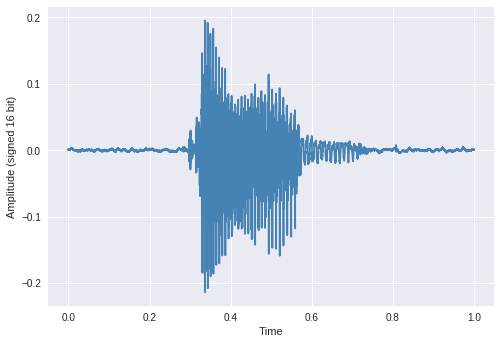

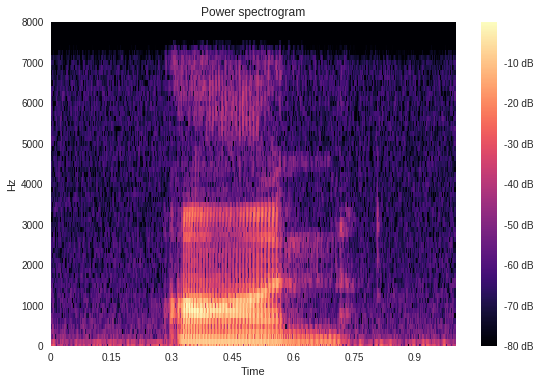

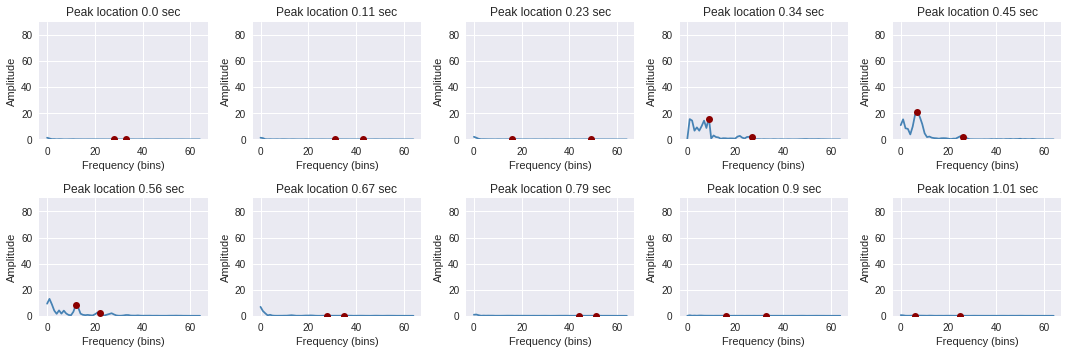

In [20]:
d_num = 0
n_fft = 128
sr = 16000

time_list = np.linspace(1, len(data_list[1]), num=len(data_list[1]))*(1/sr)

plt.plot(time_list, data_list[d_num, :], color='steelblue')
#plt.xlim(0, 1/sr * 3500)
plt.xlabel('Time')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()

# STFT
# + 1 to avoid log of 0
D_ = np.abs( librosa.stft(data_list[d_num, :] ,n_fft=n_fft ,hop_length=int(n_fft*0.325) ))
librosa.display.specshow(librosa.amplitude_to_db(D_,ref=np.max),
                         sr=sr,
                         hop_length=int(n_fft*0.325),
                         y_axis='linear', 
                         x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
#plt.xlim( 0, 1/sr * 3500)
plt.tight_layout()

print(D_.shape)

#D_ = abs(librosa.amplitude_to_db(D,ref=np.max))*100
D_ = 20 * np.log(D_ + 1)#20 * np.log( np.abs( librosa.stft(data_list[d_num, :] ,n_fft=n_fft ,hop_length=int(n_fft*0.325) )) + 1)

sersiz = 3 #10 at nfft=1024  #2 at nfft=64
n_peaks = 2
disp_n = 10-1

plt.figure(figsize=(15, 12))
for n,i in enumerate(range(1,D_.shape[1], D_.shape[1]//disp_n)):
    plt.subplot(5,5, n+1)
    plot_data = D_[:,i]
    values, locs = peakfind(plot_data, l_size=sersiz, r_size=sersiz, c_size=sersiz, n_peaks=n_peaks)
    fp = locs[values > -1]
    print(fp)
    fv = values[values > -1]
    plt.plot(plot_data, color='steelblue')#, marker='p'
    plt.plot(fp, fv, marker='o', color='darkred', linestyle='None')
    plt.title('Peak location %s sec'%str(round(i*n_fft*0.325/sr,2)))
    #plt.xlim(0,27)
    plt.ylim(0,90)
    plt.xlabel('Frequency (bins)')
    plt.ylabel('Amplitude')
plt.tight_layout()

In [24]:
print(24/(24+19))
print(19/(24+19))
print(4/(4+11))
print(11/(4+11))

0.5581395348837209
0.4418604651162791
0.26666666666666666
0.7333333333333333


#MFCC, ΔMFCC，ΔΔMFCC

(13, 49)


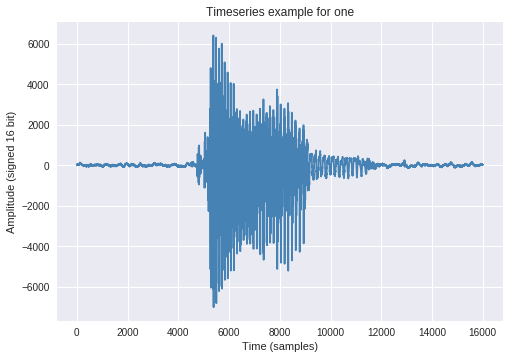

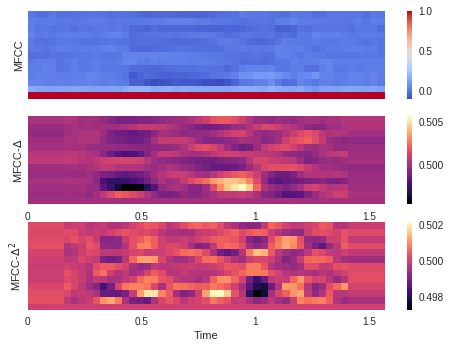

In [130]:
d_num = 0

# MFCC n_mels
n_fft = 1024
n_mfcc = 13
sersiz = 2
n_peaks = 2


plt.plot(data_list[d_num, :], color='steelblue')
plt.title('Timeseries example for %s'%labels[0])
#plt.xlim(0, 3500)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()

mfcc_freq = librosa.feature.mfcc(S=calculate_melsp( data_list[d_num, :], 
                                            n_fft=1024, hop_length=int(n_fft * 0.325), n_mels=64*2 ) , 
                                            n_mfcc=n_mfcc )

#mfcc_freq = mfcc_freq / mfcc_freq[0]

print(mfcc_freq.shape)
#librosa.display.specshow(mfcc_freq, sr=16000, x_axis='time',hop_length=int(n_fft*0.325))# x_axis='time'
#plt.colorbar()
#plt.ylabel('Freq (bin)')
#plt.xlabel('Time')
#plt.show()

mfcc_freq = mfcc_freq/mfcc_freq[0] 
delta_mfcc  = librosa.feature.delta(mfcc_freq)
delta2_mfcc = librosa.feature.delta(mfcc_freq, order=2)

plt.subplot(3,1,1)
librosa.display.specshow(mfcc_freq)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow( sigmoid(librosa.feature.delta(mfcc_freq),a=1,b=0), sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(sigmoid(librosa.feature.delta(mfcc_freq, order=2),a=1,b=0), sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

#mfcc_freq = mfcc_freq.T

#plt.figure(figsize=(12, 8))
#for n,i in enumerate(range(1,mfcc_freq.shape[0],mfcc_freq.shape[0]//9)):
#    plt.subplot(2,5, n+1)
#    plot_data = (mfcc_freq[i, :])
#    values, locs = peakfind(plot_data, l_size=sersiz, r_size=sersiz, c_size=sersiz, n_peaks=n_peaks)
#    fp = locs[values > -1]
#    fv = values[values > -1]
#    plt.plot(plot_data, color='steelblue', marker='p')
#    plt.plot(fp, fv, marker='o', color='darkred', linestyle='None')
#    plt.title('Peak location example %d'%(i))
#    plt.xlabel('Frequency (bins)')
#    plt.ylabel('Amplitude')
#plt.tight_layout()


In [131]:
##peakfind(x, n_peaks, l_size=1, r_size=1, c_size=1, f=np.mean):
##calculate_melsp(x, n_fft=64, hop_length=32):#1024,128:

#n_fft_
#n_sersiz
#n_mfcc
#n_dim

n_rand = 3

mfcc_mode = 0
mfcc_dmfcc_ddmfcc = 1
spectrogram = 0

start = time.time()
for n_fft_ in [512]:
    for n_sersiz in [2]:
        for n_mfcc_ in [10,13]:
            for n_dim in [2,3]:
              
                if spectrogram == 1:
                    all_obs = []
                    for i in range(data_list.shape[0]):
                        d = 20 * np.log( np.abs( librosa.stft(data_list[i, :] ,n_fft=n_fft ,hop_length=int(n_fft*0.325) )) + 1)
                        d = d.T
                        obs = np.zeros((n_dim, d.shape[0]))
                        for r in range(d.shape[0]):#
                            _, t = peakfind(d[r, :], n_peaks=n_dim, l_size=n_sersiz, r_size=n_sersiz, c_size=n_sersiz)
                            obs[:, r] = t.copy()
                        #if i % 10 == 0:
                            #print("Processed obs %s" % i)
                        all_obs.append(obs)              
              
              
              
                if mfcc_mode == 1:
                    all_obs = []
                    for i in range(data_list.shape[0]):
                        d = librosa.feature.mfcc(S=calculate_melsp( data_list[i, :], 
                                            n_fft=n_fft_, hop_length=int(n_fft_ * 0.325), n_mels=128 ) , 
                                            n_mfcc=n_mfcc_ )
                        
                        d = d.T
                        obs = np.zeros((n_dim, d.shape[0]))
                        for r in range(d.shape[0]):#
                            _, t = peakfind(d[r, :], n_peaks=n_dim, l_size=n_sersiz, r_size=n_sersiz, c_size=n_sersiz)
                            obs[:, r] = t.copy()
                        #if i % 10 == 0:
                            #print("Processed obs %s" % i)
                        all_obs.append(obs)
                    
                if mfcc_dmfcc_ddmfcc == 1:
                    all_obs = []
                    for i in range(data_list.shape[0]):
                        d  = librosa.feature.mfcc(S=calculate_melsp( data_list[i, :], 
                                            n_fft=n_fft_, hop_length=int(n_fft_ * 0.325), n_mels=128 ) , 
                                            n_mfcc=n_mfcc_ )
                        d = d/d[0]
                        dd = sigmoid(librosa.feature.delta(d),a=1,b=0)#a=5,b=-5
                        ddd = sigmoid(librosa.feature.delta(d, order=2),a=1,b=0)
                        
                        mfccs = np.concatenate([d, dd, ddd])
                        #mfccs = dd
                        #obs = np.zeros( (n_dim, d.shape[0]) )
                        all_obs.append(mfccs)

                all_obs = np.atleast_3d(all_obs)                

                for n,i in enumerate(all_obs):
                    all_obs[n] /= all_obs[n].sum(axis=0)
                
                all_obs = all_obs/np.max(all_obs)
                
                acc_list = []
                for random_state_ in range(n_rand):
                    X_train, X_test, y_train, y_test = train_test_split(all_obs, all_labels, test_size=0.3, random_state=random_state_)
    
                    #print('Size of training matrix:', X_train.shape)
                    #print('Size of testing matrix:', X_test.shape)
    
                    ys = set(all_labels)
                    ms = [gmmhmm(n_dim) for y in ys]
                    _ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
                    ps = [m.transform(X_test) for m in ms]
                    res = np.vstack(ps)
                    predicted_labels = np.argmax(res, axis=0)
                    missed = (predicted_labels != y_test)
                    acc_ = 100 * (1 - np.mean(missed))
                    acc_list.append(acc_)
                acc = np.mean(acc_list)
                
                elapsed_time = time.time() - start
                print("elapsed_time:{0}".format(elapsed_time) + "[sec]   " + ' n_fft_, n_sersiz:, n_mfcc:, n_dim:, Test acc:  %d, %d, %d, %d,  %.2f percent' % (n_fft_, n_sersiz, n_mfcc_, n_dim, acc))
                


elapsed_time:41.41619300842285[sec]    n_fft_, n_sersiz:, n_mfcc:, n_dim:, Test acc:  512, 2, 10, 2,  8.89 percent
elapsed_time:85.74198842048645[sec]    n_fft_, n_sersiz:, n_mfcc:, n_dim:, Test acc:  512, 2, 10, 3,  9.44 percent
elapsed_time:150.36347603797913[sec]    n_fft_, n_sersiz:, n_mfcc:, n_dim:, Test acc:  512, 2, 13, 2,  8.33 percent
elapsed_time:219.7355637550354[sec]    n_fft_, n_sersiz:, n_mfcc:, n_dim:, Test acc:  512, 2, 13, 3,  9.44 percent


In [115]:
acc_list

[5.000000000000004, 13.33333333333333, 6.666666666666665]

Text(0.5, 0, 'Predicted label')

<Figure size 1440x1440 with 0 Axes>

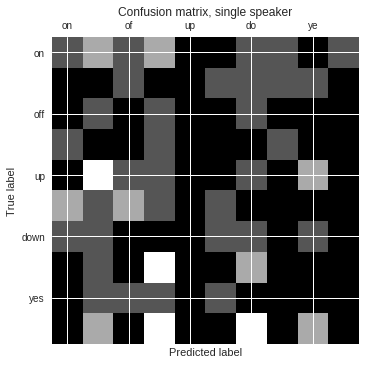

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(20, 20))
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels([" "] + [l[:2] for l in spoken])
_ = ax.set_yticklabels([" "] + spoken)
plt.title('Confusion matrix, single speaker')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# For ppt

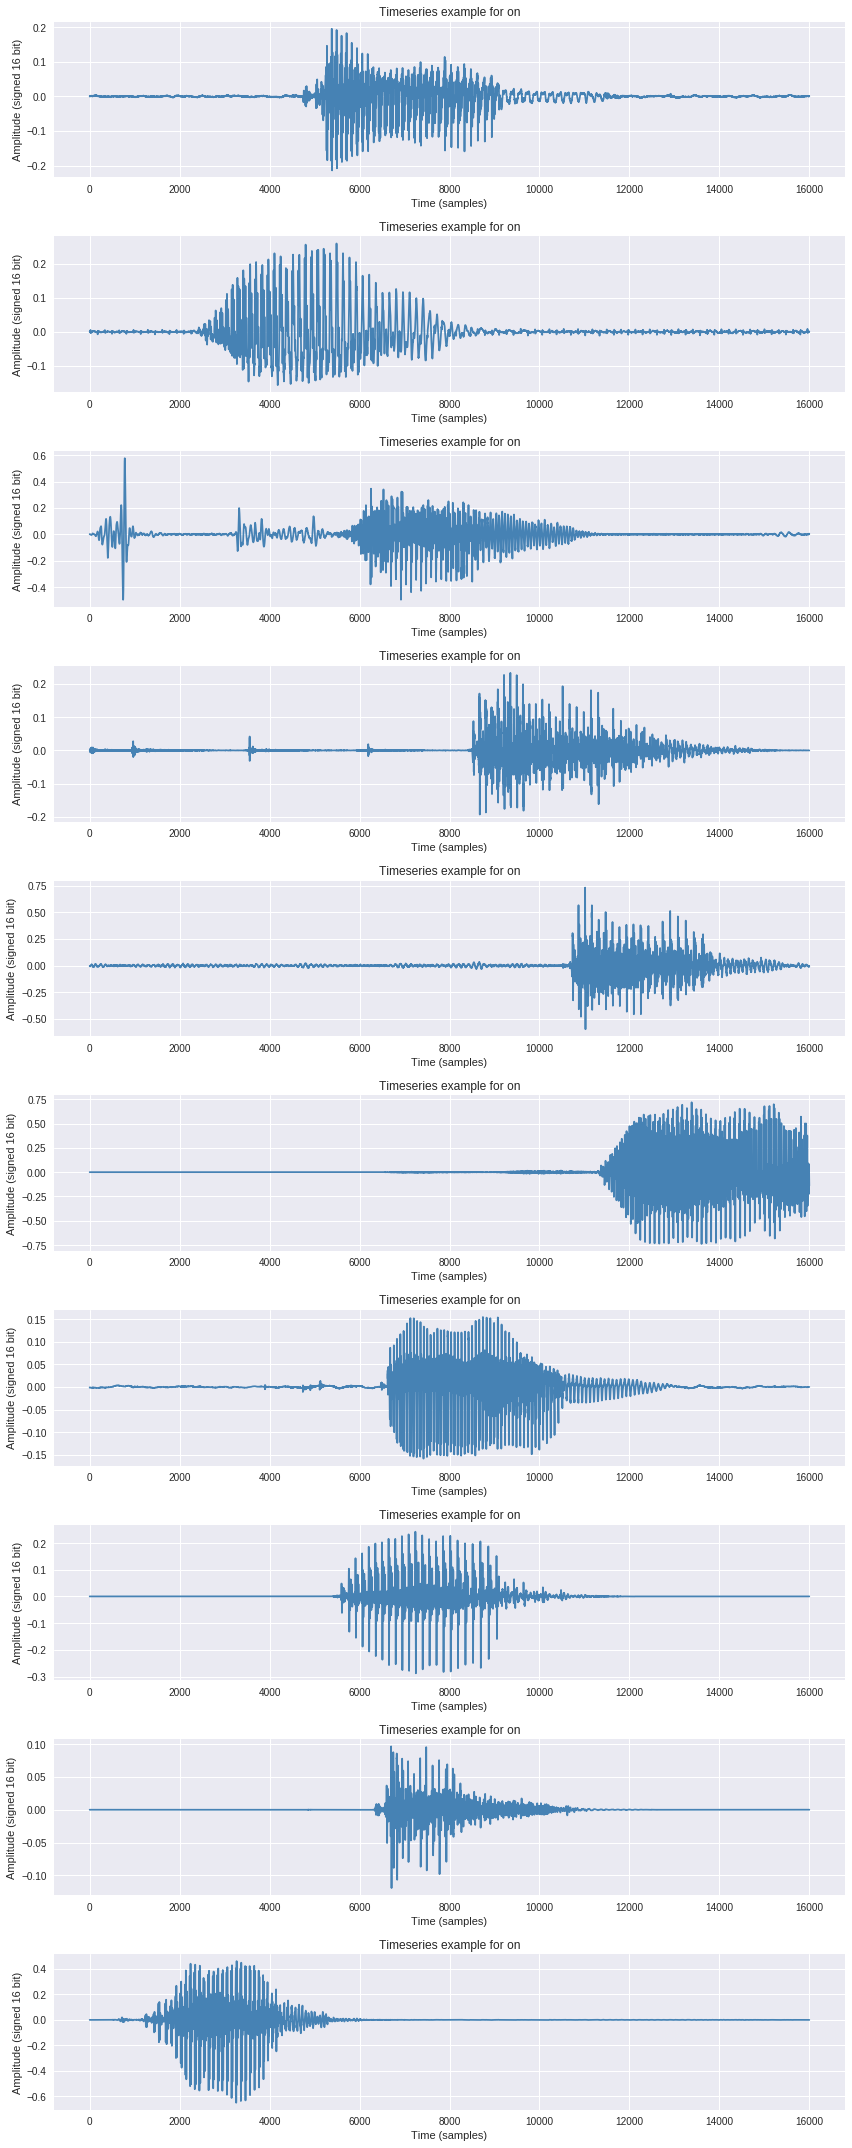

In [0]:
d_num = 10

# MFCC n_mels
n_fft = 1024
n_mfcc=20
sersiz = 2
n_peaks = 3

plt.figure(figsize=(12, 30))
for n,iii in enumerate(range(d_num)):
    plt.subplot(d_num,1,n+1)
    plt.plot(data_list[iii, :], color='steelblue')
    plt.title('Timeseries example for %s'%spoken[0])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (signed 16 bit)')
    
plt.tight_layout()